In [1]:
import sys
sys.path.append('..')
from pathlib import PurePath
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules
from models import *
from modules.data_io import (
    ALL_DATA,
    load_data_marginals,
    load_data_means,
    load_data_covariances,
    load_single_species_data,
    NUM_TIMES,
    NUM_REPLICAS,
    NUM_MEASUREMENTS,
    CONDITIONS,
    REPLICA_LABELS,
    TIME_LABELS
)
plt.rc("axes", grid="on")

In [2]:
T_MEASUREMENTS = 3600*np.array([0, 0.5, 1, 2, 4])
SPECIES = ['il1b', 'tnfa']
DATA_MEANS = load_data_means()
DATA_COVARIANCES = load_data_covariances()
DATA_MARGINALS = load_data_marginals()

In [3]:
models = ['AA', 'AB', 'AC', 'BA', 'BB', 'BC', 'CA', 'CB', 'CC']
predictions = {}
fits = {}
for i, model in enumerate(models):
    with np.load(f"predictions/joint_fit/3S{model}_predictions.npz", allow_pickle=True) as _:
        predictions[model] = _["predictions"][()]
    with np.load(f'opt_results/joint_fit/3S{model}_best_joint_fit.npz') as _:
        fits[model] = _["xs"]

In [4]:
species_labels = {'tnfa': rf"TNF-$\alpha$",
                  'il1b': rf"IL-1$\beta$"}

cond_labels = {'NoInhibitors': 'No Inhibitors',
               'MG': 'MG132',
               'U0126': 'U0126',
               'MG_U0126': 'Combined'}
cond_colors = {'NoInhibitors': 'red',
               'MG': 'blue',
               'U0126': 'orange',
               'MG_U0126': 'darkgreen'}
cond_ls = {'NoInhibitors': '-',
           'MG': '-.',
           'U0126': '--',
           'MG_U0126': ':'}
cond_markers = {
        "NoInhibitors": "v",
        "MG": "o",
        "U0126": "x",
        "MG_U0126": "*"
}

# Fits of the best model to data

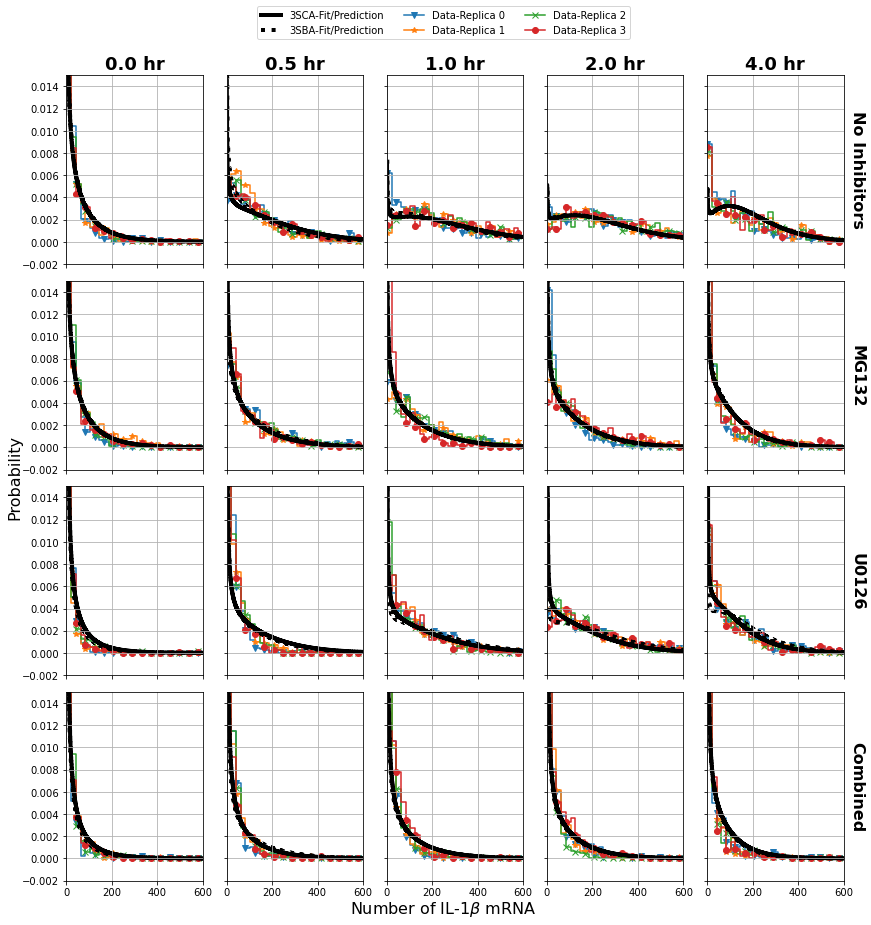

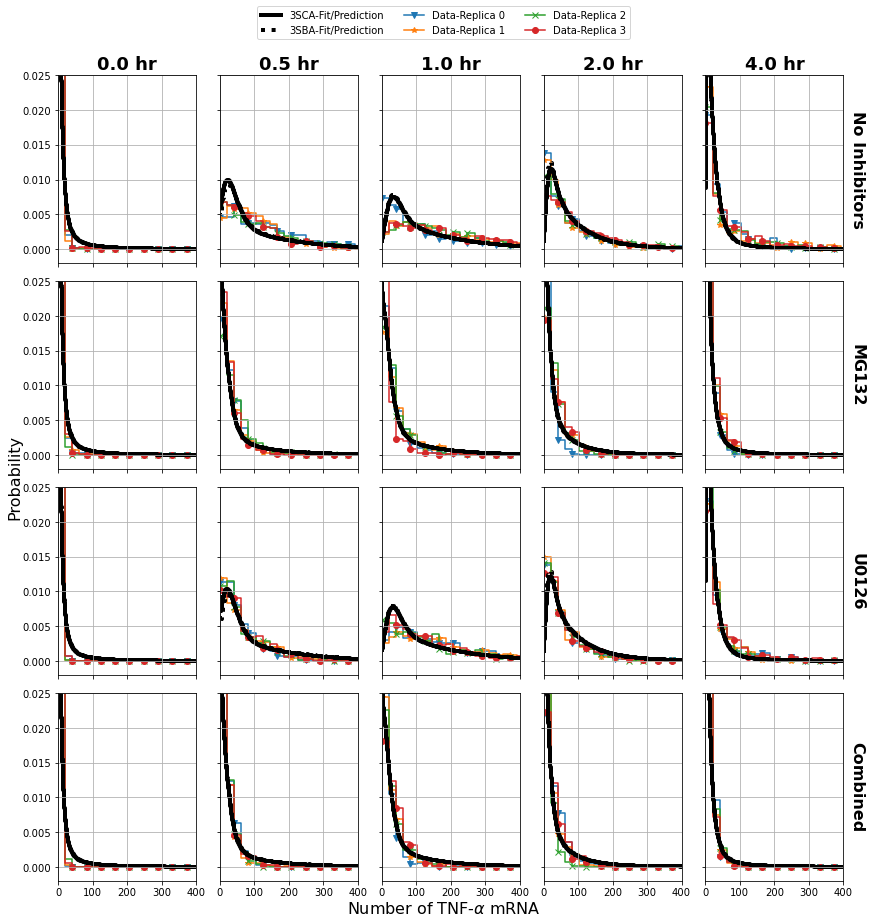

In [5]:
best_models = ["CA", "BA"]
xlimits = {'tnfa': [0, 400], 'il1b': [0, 600]}
ylimits = {'tnfa': [-0.002, 0.025], 'il1b':[-0.002, 0.015]}
rep_markers = ['v', '*', 'x', 'o']
for species in SPECIES:
    fig, axes = plt.subplots(len(CONDITIONS),
                             len(T_MEASUREMENTS),
                             sharex=True,
                             sharey=True)
    fig.set_size_inches(12, 12)
    fig.set_tight_layout(True)
    for i, condition in enumerate(CONDITIONS):
        data = load_single_species_data(condition, species)
        for j in range(len(T_MEASUREMENTS)):
            for model in best_models:
                # Model predictions
                p_model = np.copy(predictions[model][species][condition][f"p{j}"])
                p_model[p_model < 1.0e-8] = 1.0e-8
                fit_label = f"3S{model}-Fit/Prediction"
                xmax = len(p_model)
                axes[i,j].plot(p_model, label=fit_label, color="k",
                         linewidth=4, alpha=1,
                         linestyle="-" if model=="CA" else ":",
                         drawstyle='steps-post', zorder=1)

            for rep in range(0, 4):
                data = load_single_species_data(condition, species, rep)
                fit_h, fit_edges = np.histogram(data[j],
                                            bins=np.linspace(0, 600, 600//20),
                                            density=True)
                axes[i,j].plot(fit_edges[:-1], fit_h,
                               label=f"Data-Replica {rep}",
                               marker=rep_markers[rep], markevery=2,
                               drawstyle='steps-post', zorder=0)

            axes[i,j].set_xlim(xlimits[species])
            axes[i,j].set_ylim(ylimits[species])

            if i == 0:
                axes[i,j].set_title(f'{T_MEASUREMENTS[j]/3600} hr',
                                    fontsize=18,
                                    fontweight='bold')
            # elif i == 3:
            #     axes[i,j].set_xlabel('RNA copy number')
            #
            # if j == 0:
            #     axes[i,j].set_ylabel('Probability')
            if j == 4:
                axes[i,j].annotate(cond_labels[condition],
                                   xy=(1.1, 0.5),
                                   xycoords="axes fraction",
                                   rotation=270,
                                   horizontalalignment='center',
                                   va='center',
                                   fontsize=16,
                                   fontweight="bold")

    h, l = axes[0,0].get_legend_handles_labels()

    fig.text(0.5, -0.005, f"Number of "
                        rf"{species_labels[species]}"
                        rf" mRNA", ha="center", fontsize=16)
    fig.text(-0.005, 0.5, f"Probability", va="center",
             rotation="vertical", fontsize=16)

    fig.legend(h, l,
               bbox_to_anchor=(0, 1, 1, 2),
               loc="lower center",
               ncol=3)

    fig.savefig(f'figs/{species.lower()}_distributions.png',
                dpi = 500,
                bbox_inches='tight')



# Change in mRNA distribution under treatment by small-molecule inhibitors

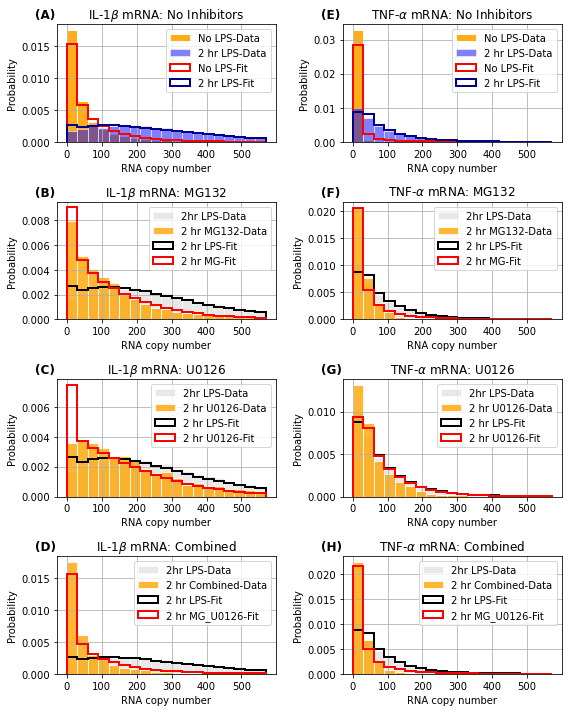

In [6]:
fig, axes = plt.subplots(4,2)
fig.set_size_inches(8,10)
fig.set_tight_layout(True)

# bins = np.concatenate((np.array([0, 1, 2]), np.linspace(0, 1000, 40)))
bins = np.arange(0, 600, 30)
bins = np.unique(bins)

itime = 3

best_model= "CA"

def plot_marginal_as_binned(p_model, bins, ax, **kwargs):
    p_model[p_model < 1.0e-8] = 1.0e-8
    ax.hist(x=np.arange(0, len(p_model)), bins=bins, weights=p_model, density=True, **kwargs)

for icol, species in enumerate(SPECIES):
    # FIRST ROW: COMPARE 0hr vs itime-hr with no inhibitors
    data_no_drug = load_single_species_data("NoInhibitors", species)
    axes[0, icol].hist(x=data_no_drug[0], bins=bins, density=True, color='orange', alpha=0.9,
                       edgecolor='white', label='No LPS-Data')
    axes[0, icol].hist(x=data_no_drug[itime], bins=bins, density=True, color='blue', alpha=0.5,
                       edgecolor='white', label='2 hr LPS-Data')
    plot_marginal_as_binned(predictions[best_model][species]["NoInhibitors"]["p0"],
                            bins, axes[0, icol],
                            edgecolor='red', linewidth=2, histtype='step',
                            label='No LPS-Fit')
    plot_marginal_as_binned(predictions[best_model][species]["NoInhibitors"][f"p{itime}"],
                            bins, axes[0, icol],
                            edgecolor='darkblue', linewidth=2, histtype='step',
                            label='2 hr LPS-Fit')
    axes[0, icol].set_title(f"{species_labels[species]} mRNA: No Inhibitors")

    # REST OF THEM: COMPARE DISTRIBUTIONS AT ITIME-TH TIMEPOINT WITH AND WITHOUT DRUG
    for irow, condition in enumerate(CONDITIONS[1:]):
        data = load_single_species_data(condition, species)
        axes[irow+1, icol].hist(x=data_no_drug[itime], bins=bins, density=True,
                                color='lightgrey',
                                edgecolor='white',
                                label='2hr LPS-Data',
                                alpha=0.5)
        axes[irow+1, icol].hist(x=data[itime], bins=bins, density=True, color='orange',
                                alpha=0.8,
                       edgecolor='white', label=f'2 hr {cond_labels[condition]}-Data')
        plot_marginal_as_binned(predictions[best_model][species]["NoInhibitors"][f"p{itime}"],
                            bins, axes[irow+1, icol],
                            edgecolor='k', linewidth=2, histtype='step',
                            label='2 hr LPS-Fit')
        plot_marginal_as_binned(predictions[best_model][species][condition][f"p{itime}"],
                            bins, axes[irow+1, icol],
                            edgecolor='red', linewidth=2, histtype='step',
                            label=f'2 hr {condition}-Fit')
        axes[irow+1, icol].set_title(f"{species_labels[species]} mRNA: {cond_labels[condition]}")

for ax in axes.flatten():
    ax.set_xlabel("RNA copy number")
    ax.set_ylabel("Probability")
    ax.legend(loc="best")

from string import ascii_uppercase
for i in range(0, 4):
    for j in range(0, 2):
        axes[i, j].annotate(f"({ascii_uppercase[i + 4*j]})", fontweight="bold",
                            xy=(-0.1, 1.05), xycoords="axes fraction", fontsize=12)
fig.savefig(f"figs/marginal_fits_supperposition.png", dpi=700, bbox_inches="tight")

# Time-varying mean mRNA copy numbers

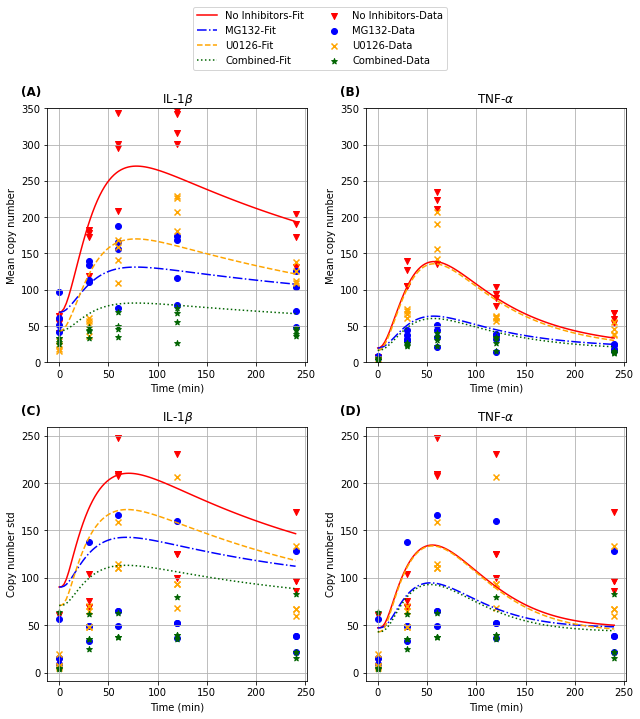

In [7]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(2*4 + 1, 9)
fig.set_tight_layout(True)
best_model = "CA"
for condition in CONDITIONS:
    for j, species in enumerate(SPECIES):
        # Model-predicted means
        axs[0, j].plot(predictions[best_model][species][condition]['tnodes']/ 60 ,
                    predictions[best_model][species][condition]['mean'],
                label=f"{cond_labels[condition]}-Fit",
                color=cond_colors[condition], linestyle=cond_ls[condition])

        # Mean measurements across replicas
        axs[0, j].scatter([T_MEASUREMENTS/60]*NUM_REPLICAS,
                       DATA_MEANS[condition][species][0:4],
                       color=cond_colors[condition],
                       label=f"{cond_labels[condition]}-Data", marker=cond_markers[condition])
        axs[0, j].set_ylim([0, 350])
        axs[0, j].set_xlabel('Time (min)')
        axs[0, j].set_ylabel('Mean copy number')
        axs[0, j].set_title(species_labels[species])

        # Model-predicted Std
        axs[1, j].plot(predictions[best_model][species][condition]['tnodes']/ 60 ,
                    np.sqrt(predictions[best_model][species][condition]['var']),
                label=f"{cond_labels[condition]}-Fit",
                color=cond_colors[condition], linestyle=cond_ls[condition])

        # Std measurements across replicas
        axs[1, j].scatter([T_MEASUREMENTS/60]*NUM_REPLICAS,
                       np.sqrt(DATA_COVARIANCES[condition].diagonal()),
                       color=cond_colors[condition],
                       label=f"{cond_labels[condition]}-Data", marker=cond_markers[condition])
        # axs[1, j].set_ylim([0, 350])
        axs[1, j].set_xlabel('Time (min)')
        axs[1, j].set_ylabel('Copy number std')
        axs[1, j].set_title(species_labels[species])

h, l = axs[0, 0].get_legend_handles_labels()

for i, ax in enumerate(list(axs.flatten())):
    ax.annotate(f"({ascii_uppercase[i]})", fontweight="bold",
                            xy=(-0.1, 1.05), xycoords="axes fraction", fontsize=12)

fig.legend(h, l, loc="lower center", bbox_to_anchor=(0, 1, 1, 2), ncol=2)
fig.savefig(f'figs/single_drug_means_vars.png', dpi=700, bbox_inches="tight")

In [8]:
import pandas as pd

CM1 = ["C", "A"]
CM2 = ["B", "A"]
parameter_sets = []
for i, comb_model in enumerate([CM1, CM2]):
    il1b_model = comb_model[0]
    tnfa_model = comb_model[1]
    model = CombinedModel(il1b_model, tnfa_model)
    fit_file = f'opt_results/joint_fit/3S{il1b_model}{tnfa_model}_best_joint_fit.npz'
    with np.load(fit_file) as _:
        fit = _["xs"]
    d = []
    for par in model.PARAMETERS:
        d.append([par, 10.0**fit[model.PARAMETER_INDICES[par]]])
    parameter_table = pd.DataFrame(d)
    parameter_table.to_csv(f"tables/3S{il1b_model}{tnfa_model}_best_fit.csv", float_format = "%.2e")

    print(f"Parameters for combinatorial model {i+1} (CM{i+1} in the main text)")
    print(parameter_table)
    parameter_sets.append(parameter_table)

Parameters for combinatorial model 1 (CM1 in the main text)
                  0         1
0                r1  0.000901
1                r2  0.000305
2          k01_il1b  0.038909
3          k10_il1b  0.007622
4         k12a_il1b  0.000039
5         k12b_il1b  0.009601
6          k21_il1b  0.008373
7       alpha0_il1b  0.000109
8       alpha1_il1b  0.000016
9       alpha2_il1b  0.998611
10       gamma_il1b  0.000057
11     k12b_il1b_MG  0.002826
12   k01_il1b_U0126  0.008007
13        k01a_tnfa  0.000121
14        k01b_tnfa  0.022674
15         k10_tnfa  0.046743
16         k12_tnfa  0.008188
17         k21_tnfa  0.003981
18      alpha0_tnfa  0.000036
19      alpha1_tnfa  0.624152
20      alpha2_tnfa  0.539234
21       gamma_tnfa  0.000229
22     k01b_tnfa_MG  0.007800
23  k01a_tnfa_U0126  0.000100
Parameters for combinatorial model 2 (CM2 in the main text)
                  0         1
0                r1  0.001027
1                r2  0.000439
2          k01_il1b  0.004772
3         

# NFkB concentration and mean transcription rates

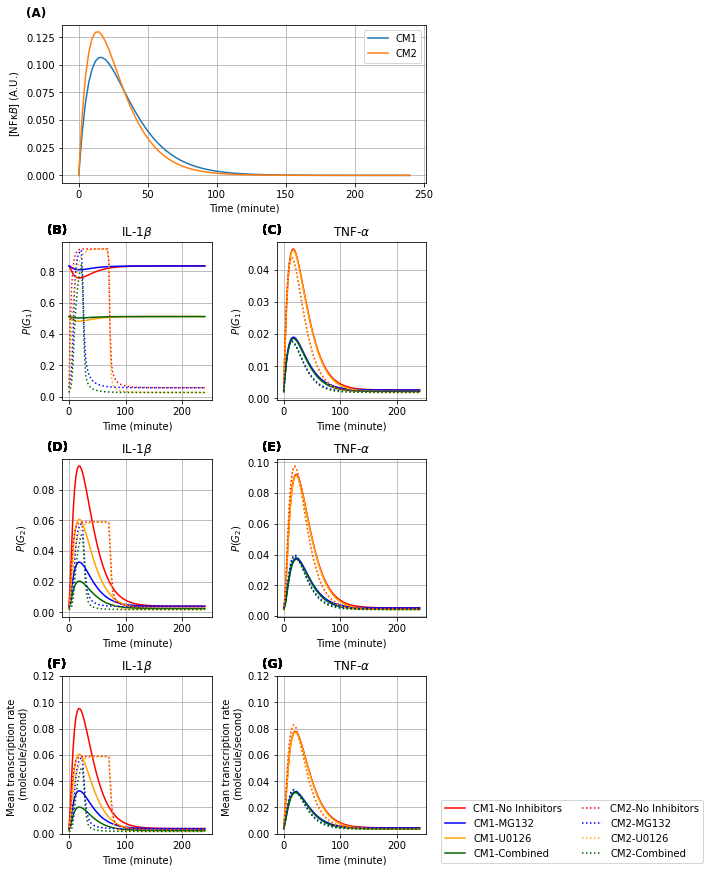

In [9]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(6, 12)
gs = plt.GridSpec(figure = fig, ncols=2, nrows=4)

ax_nfkb = fig.add_subplot(gs[0,:])
for i, model in enumerate(best_models):
    cmodel = CombinedModel(model[0], model[1])
    fit_file = f'opt_results/joint_fit/3S{model}_best_joint_fit.npz'
    with np.load(fit_file) as _:
        fit = _["xs"]
    # NFkB concentration in AU
    r1 = 10.0**fit[0]
    r2 = 10.0**fit[1]
    T = np.linspace(0, 3600*4, 100)
    s = np.exp(-r1*T)*(1- np.exp(-r2*T))
    ax_nfkb.plot(T/60, s, label=f"CM{i+1}")
ax_nfkb.set_xlabel("Time (minute)")
ax_nfkb.set_ylabel(r"$[\operatorname{NF\kappa{B}}]$ (A.U.)")
ax_nfkb.legend()
ax_nfkb.annotate(f"(A)",
                 fontweight="bold",
                 xy=(-0.1, 1.05),
                 xycoords="axes fraction",
                 fontsize=12)

for i, species in enumerate(SPECIES):
    ax0 = fig.add_subplot(gs[1,i])
    ax1 = fig.add_subplot(gs[2,i])
    ax2 = fig.add_subplot(gs[3,i])
    for imodel, model in enumerate(best_models):
        parameter_table = parameter_sets[imodel]
        for cond in CONDITIONS:
            gene_dists = predictions[model][species][cond]["gene_dists"]

            label = f"CM1-{cond_labels[cond]}" if model == "CA" \
                else f"CM2-{cond_labels[cond]}"
            ls = '-' if model == "CA" else ':'
            # Probability to be in G1 states
            ax0.plot(
                predictions[model][species][cond]["tnodes"]/60,
                gene_dists[:, 1],
                color=cond_colors[cond],
                label=label,
                linestyle=ls
            )
            ax0.set_title(species_labels[species])
            ax0.set_xlabel("Time (minute)")
            ax0.set_ylabel(r"$P(G_1)$")
            ax0.annotate(f"({ascii_uppercase[1 + i]})", fontweight="bold",
                                xy=(-0.1, 1.05), xycoords="axes fraction", fontsize=12)

            # Probability to be in G2 states
            ax1.plot(
                predictions[model][species][cond]["tnodes"]/60,
                gene_dists[:, 2],
                color=cond_colors[cond],
                label=cond_labels[cond],
                linestyle=ls
            )
            ax1.set_title(species_labels[species])
            ax1.set_xlabel("Time (minute)")
            ax1.set_ylabel(r"$P(G_2)$")
            ax1.annotate(f"({ascii_uppercase[3 + i]})", fontweight="bold",
                                xy=(-0.1, 1.05), xycoords="axes fraction", fontsize=12)

            # Mean transcription rates
            alpha0 = parameter_table[parameter_table[0]==f"alpha0_{species}"][1].to_numpy()
            alpha1 = parameter_table[parameter_table[0]==f"alpha1_{species}"][1].to_numpy()
            alpha2 = parameter_table[parameter_table[0]==f"alpha2_{species}"][1].to_numpy()

            mean_transcr = alpha0*gene_dists[:, 0] + alpha1*gene_dists[:, 1] + alpha2*gene_dists[:, 2]
            ax2.plot(
                predictions[model][species][cond]["tnodes"]/60,
                mean_transcr,
                color=cond_colors[cond],
                label=cond_labels[cond],
                linestyle=ls
            )
            ax2.set_title(species_labels[species])
            ax2.set_xlabel("Time (minute)")
            ax2.set_ylabel("Mean transcription rate \n (molecule/second)")
            ax2.set_ylim([0, 0.12])
            ax2.annotate(f"({ascii_uppercase[5 + i]})", fontweight="bold",
                                xy=(-0.1, 1.05), xycoords="axes fraction", fontsize=12)
h, l = ax0.get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(1, 0, 2, 1), loc="lower left", ncol=2)
fig.savefig("figs/signal_and_mean_transcr.png", dpi=700,
            bbox_inches="tight")

# Predictions for signal concentration and mean transcription rates by the top performing models

16
13


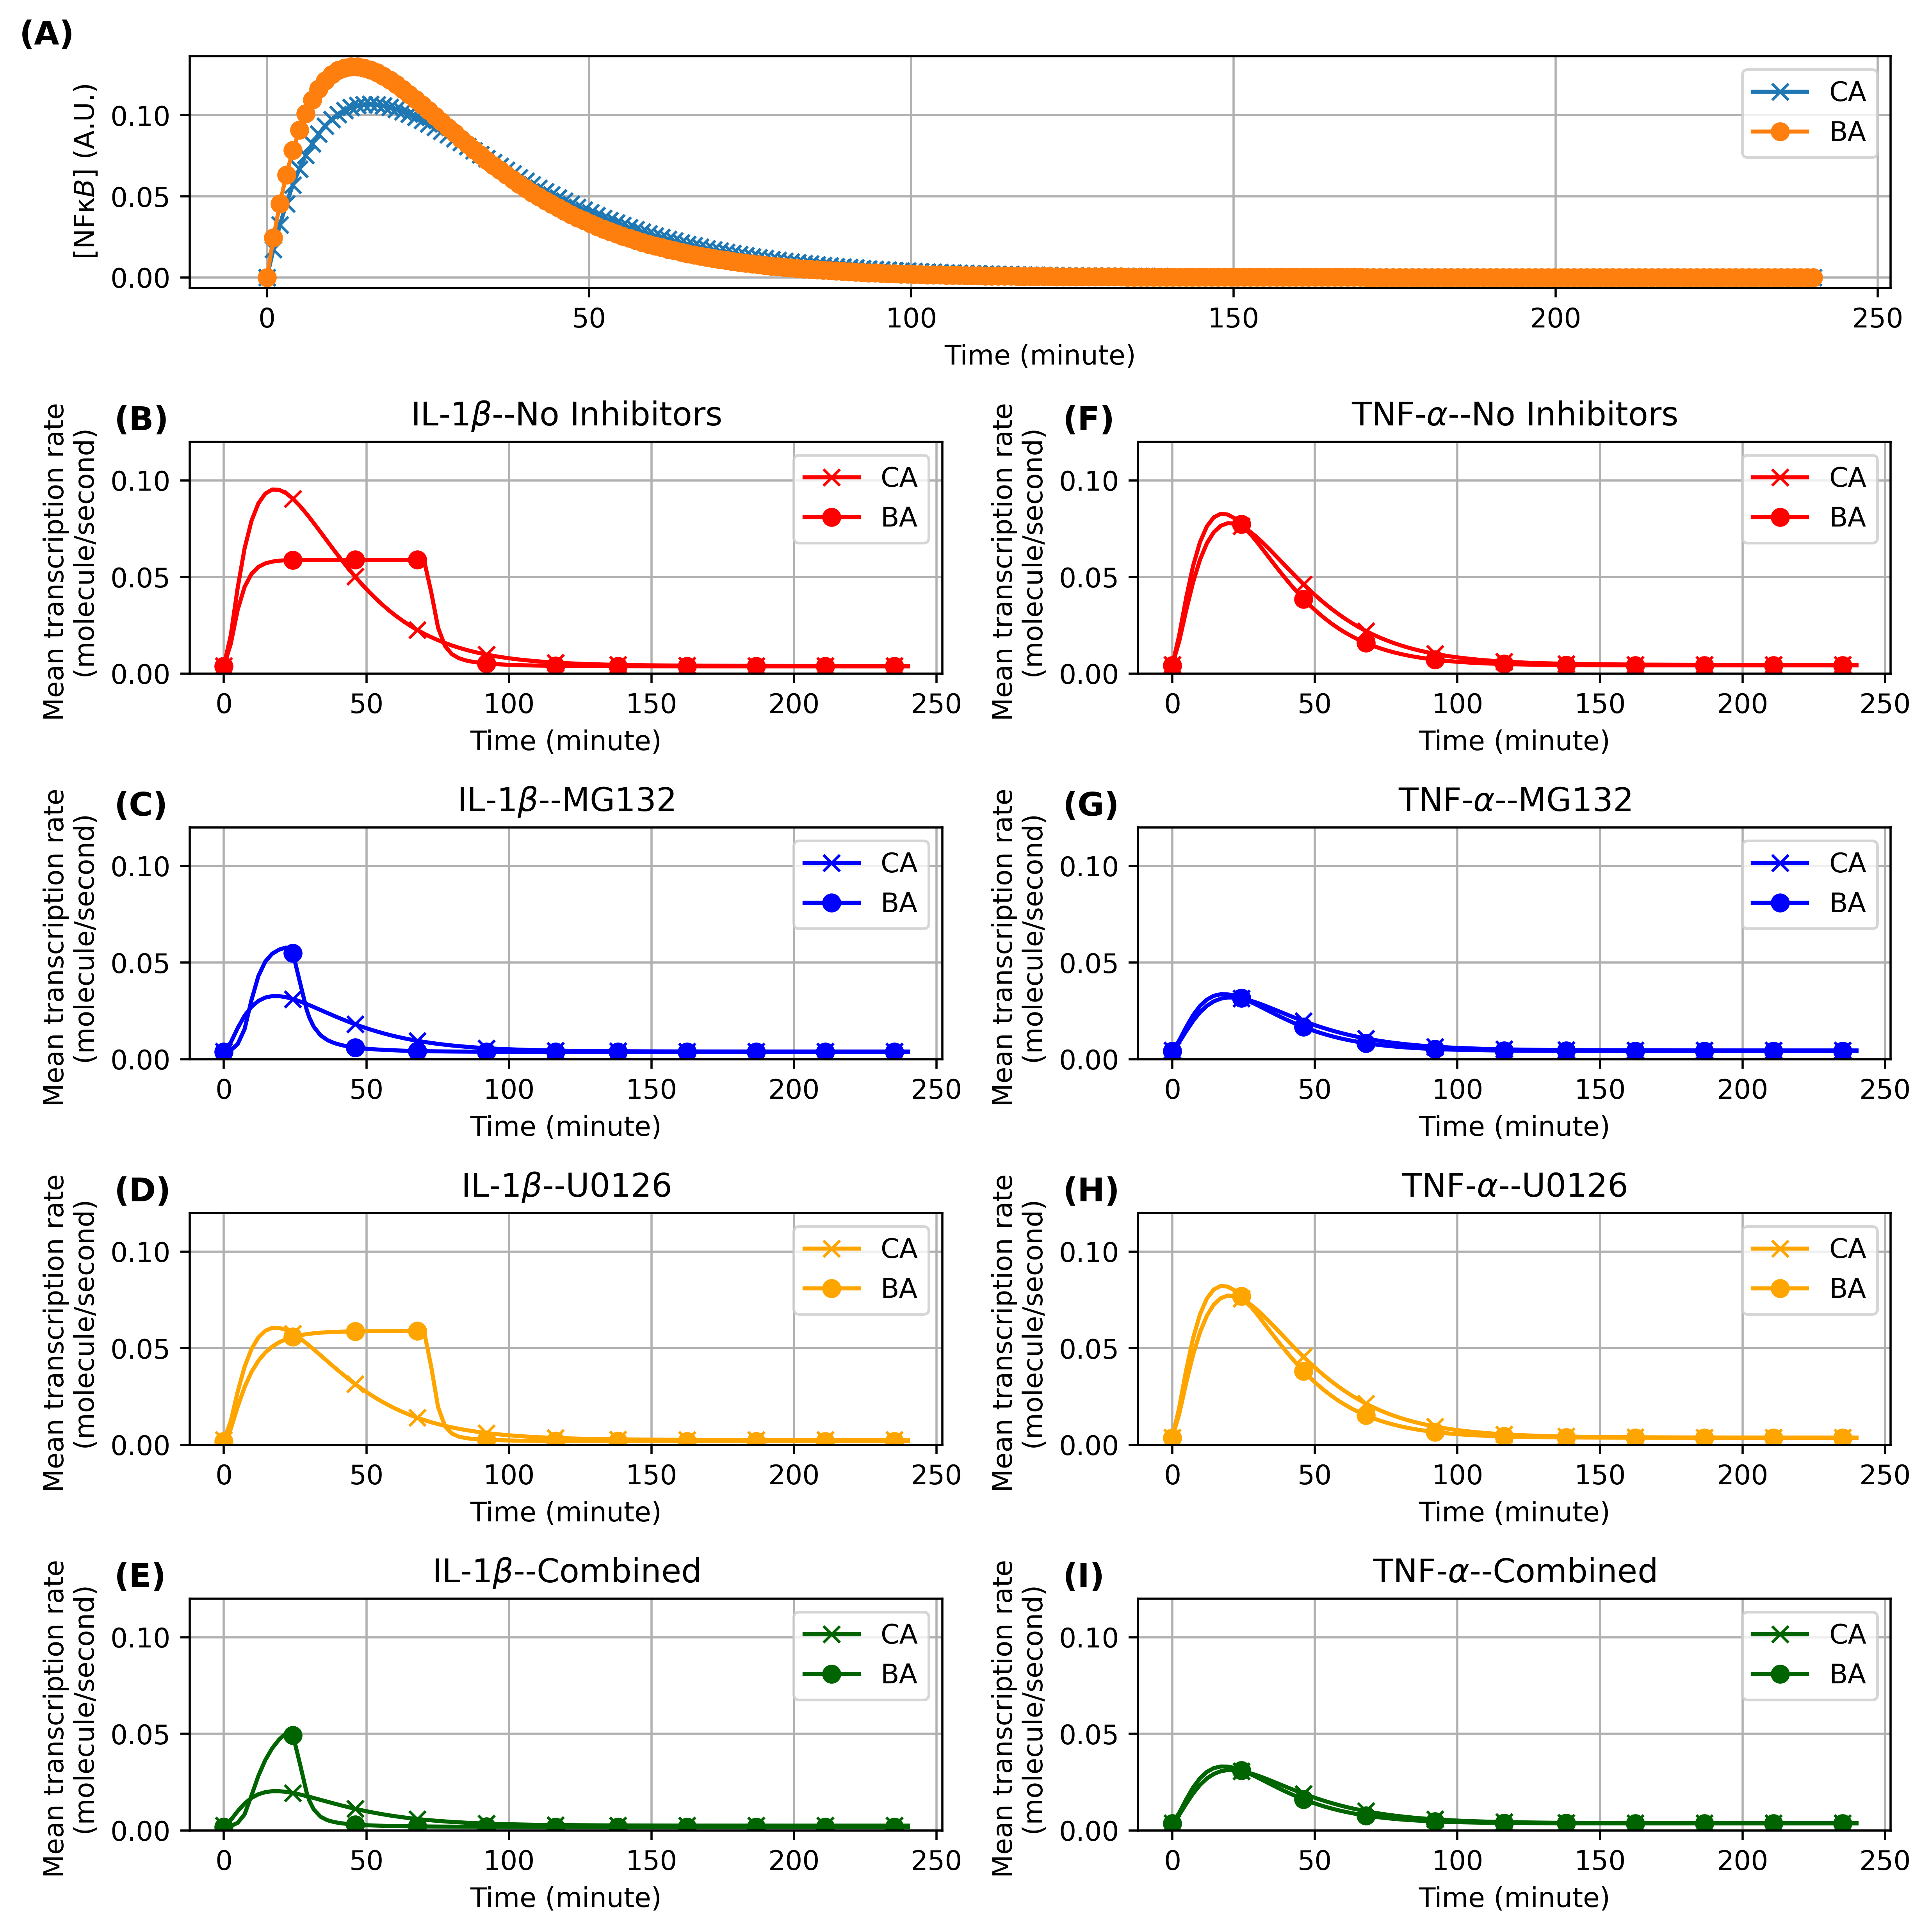

In [10]:
models = ['CA', 'BA']
markers = ['x', 'o', 'v', '*', '<', '>', '1']
fig = plt.figure(dpi=500, tight_layout=True, figsize=(10, 10))
gs = plt.GridSpec(1 + len(CONDITIONS), 2)

ax_nfkb = fig.add_subplot(gs[0,:])
transcr_axes = [[fig.add_subplot(gs[1+i, 0]), fig.add_subplot(gs[1+i, 1])] for i, cond in enumerate(CONDITIONS)]
# twintranscr_axes = [[ax.twinx() for ax in axs] for axs in transcr_axes]
for i, model in enumerate(models):
    cmodel = CombinedModel(model[0], model[1])

    fit_file = f'opt_results/joint_fit/3S{model}_best_joint_fit.npz'
    with np.load(fit_file) as _:
        fit = _["xs"]
    # NFkB concentration in AU
    r1 = 10.0**fit[0]
    r2 = 10.0**fit[1]
    T = np.linspace(0, 3600*4, 60*4)
    s = np.exp(-r1*T)*(1- np.exp(-r2*T))
    print(np.argmax(s))
    ax_nfkb.plot(T/60, s, label=model, marker=markers[i])
    ax_nfkb.set_xlabel("Time (minute)")
    ax_nfkb.set_ylabel(r"$[\operatorname{NF\kappa{B}}]$ (A.U.)")
    for icond, cond in enumerate(CONDITIONS):
        for j, species in enumerate(SPECIES):
            my_ax = transcr_axes[icond][j]

            gene_dists = predictions[model][species][cond]["gene_dists"]

            # Mean transcription rates
            alpha0 = 10.0**fits[model][cmodel.PARAMETER_INDICES[f"alpha0_{species}"]]
            alpha1 = 10.0**fits[model][cmodel.PARAMETER_INDICES[f"alpha1_{species}"]]
            alpha2 = 10.0**fits[model][cmodel.PARAMETER_INDICES[f"alpha2_{species}"]]
            deg = 10.0**fits[model][cmodel.PARAMETER_INDICES[f"gamma_{species}"]]

            mean_transcr = alpha0*gene_dists[:, 0] + alpha1*gene_dists[:, 1] + alpha2*gene_dists[:, 2]
            my_ax.plot(
                predictions[model][species][cond]["tnodes"]/60,
                mean_transcr,
                color=cond_colors[cond],
                label=model,
                marker=markers[i],
                markevery=10
            )

            my_ax.set_ylabel("Mean transcription rate \n (molecule/second)")
            my_ax.set_xlabel("Time (minute)")
            my_ax.set_title(f"{species_labels[species]}--{cond_labels[cond]}")
            my_ax.set_ylim([0, 0.12])
            my_ax.legend()

ax_nfkb.legend()
ax_nfkb.annotate(f"({ascii_uppercase[0]})",
                 fontweight="bold",
                 xy=(-0.1, 1.05), xycoords="axes fraction", fontsize=12)

for i in range(len(transcr_axes)):
    transcr_axes[i][0].annotate(f"({ascii_uppercase[1+i]})",
                 fontweight="bold",
                 xy=(-0.1, 1.05), xycoords="axes fraction", fontsize=12)
    transcr_axes[i][1].annotate(f"({ascii_uppercase[5+i]})",
                 fontweight="bold",
                 xy=(-0.1, 1.05), xycoords="axes fraction", fontsize=12)

fig.savefig("figs/compare_model_predicted_signal_transcription.png")

# Compare model-predicted means and stds

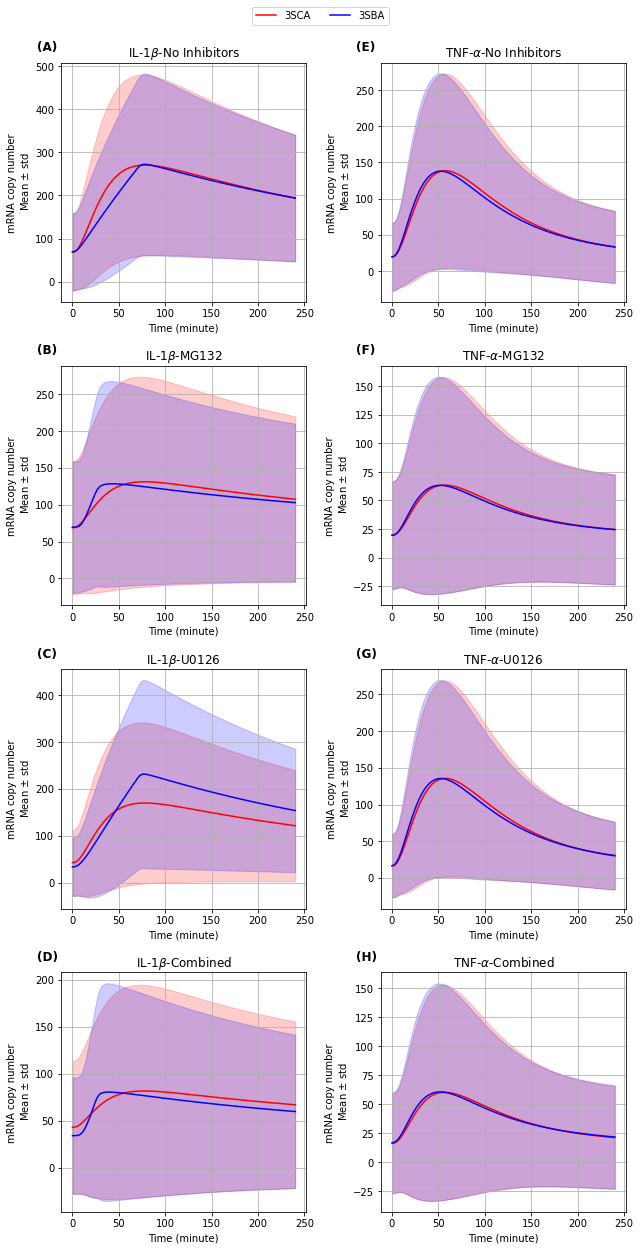

In [11]:
fig, axs = plt.subplots(len(CONDITIONS), len(SPECIES))
fig.set_size_inches(len(SPECIES)*4 + 1, len(CONDITIONS)*4+1)
fig.set_tight_layout(True)
for icond, condition in enumerate(CONDITIONS):
    for j, species in enumerate(SPECIES):
        for model in best_models:
            color = "red" if model=="CA" else "blue"

            ax = axs[icond, j]
            tnodes = predictions[model][species][condition]['tnodes']/ 60
            means = predictions[model][species][condition]['mean']
            stds = np.sqrt(predictions[model][species][condition]['var'])

            # Model-predicted means
            ax.plot(tnodes, means, label=f"3S{model}",
                               color=color)
            # Model-predicted Std stripes
            ax.fill_between(x=tnodes, y1=means+stds, y2=means-stds,
                                       label="", alpha=0.2, color=color)
            ax.set_xlabel("Time (minute)")
            ax.set_ylabel("mRNA copy number\n"
                          r" Mean $\pm$ std ")
            ax.set_title(rf"{species_labels[species]}-{cond_labels[condition]}")


h, l = axs[0, 0].get_legend_handles_labels()

for i, ax in enumerate(list(axs.flatten())):
    ax.annotate(f"({ascii_uppercase[(i//2) + 4*(i%2)]})", fontweight="bold",
                            xy=(-0.1, 1.05), xycoords="axes fraction", fontsize=12)
fig.legend(h, l, bbox_to_anchor=(0, 1, 1, 2), loc="lower center", ncol=2)
fig.savefig(f'figs/model_predicted_single_drug_means_vars.png', dpi=700, bbox_inches="tight")

